In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import splrep, splev
from math import sqrt
import seaborn as sns

In [70]:
file_path = r"drive_cycles\drive_cycle_itr8.xlsx"
dc_pred = pd.read_excel(file_path)

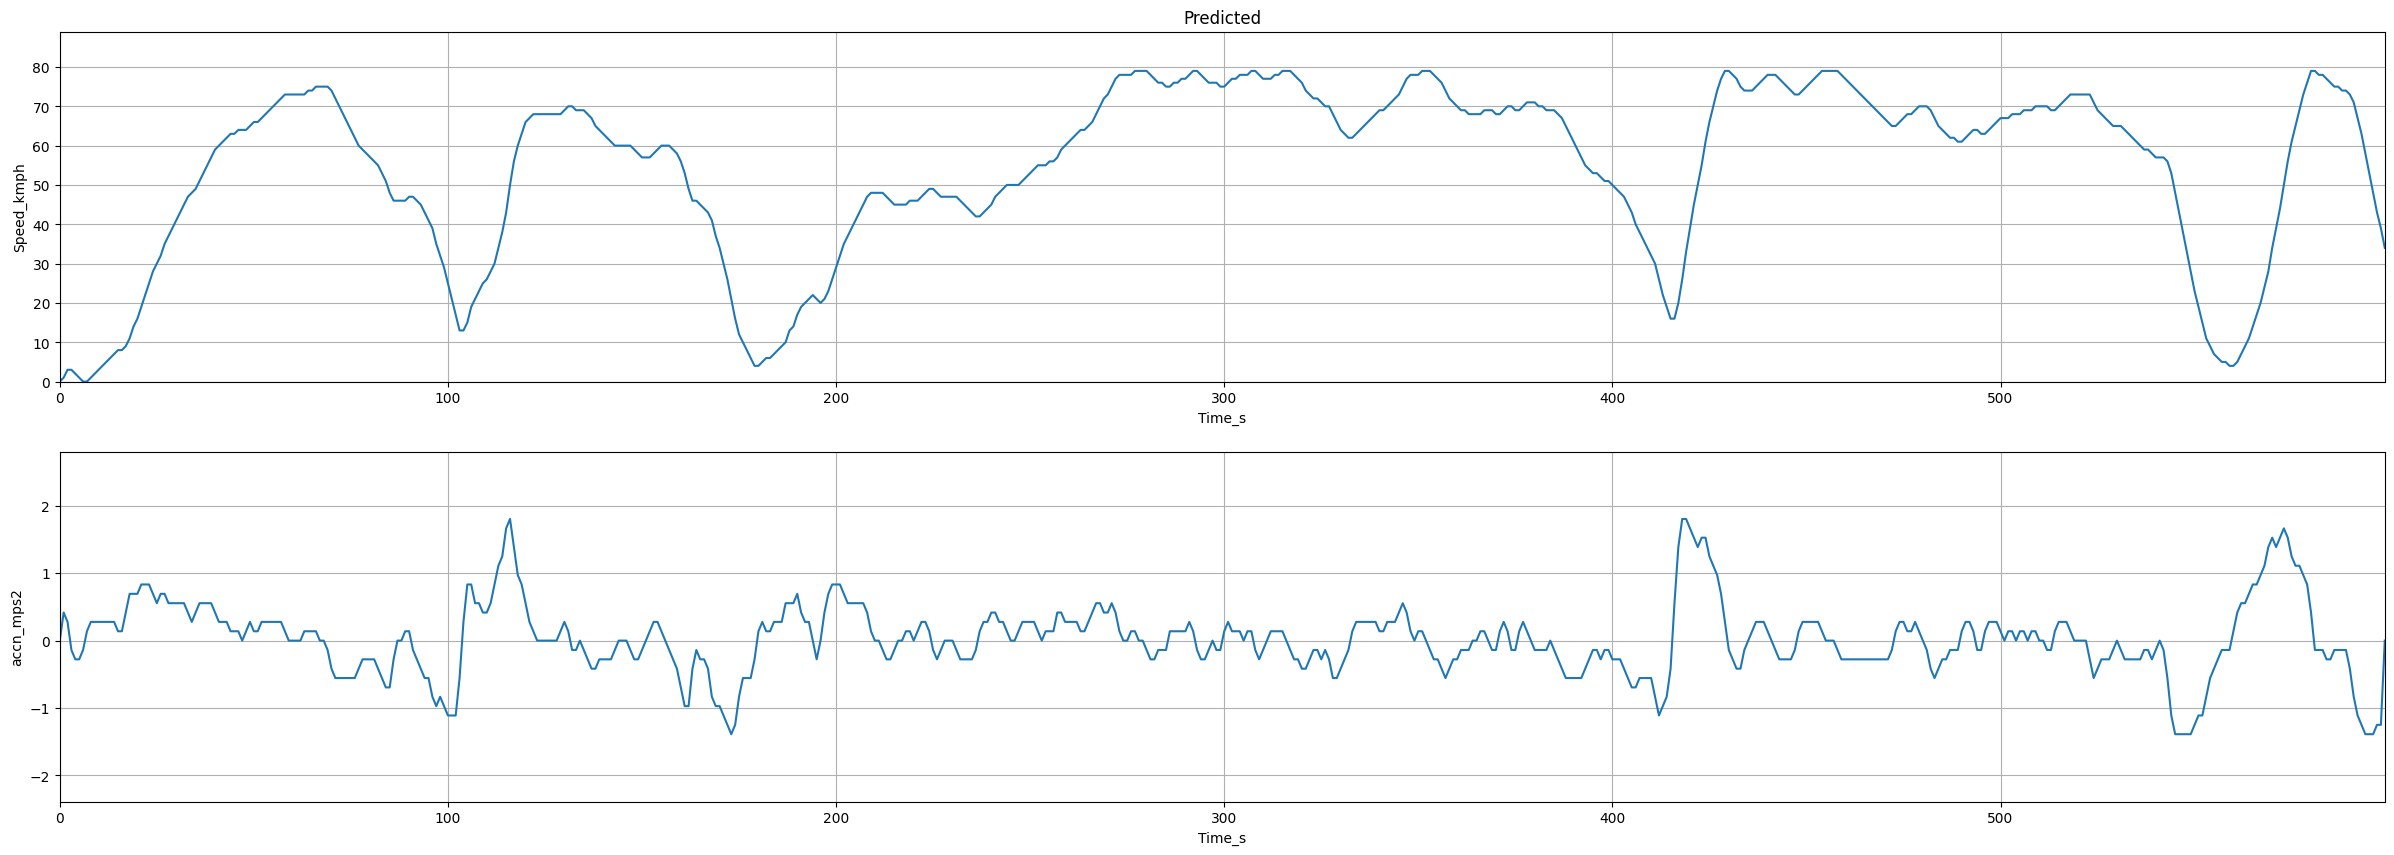

In [71]:
fig,ax = plt.subplots(2,1,figsize=[30,10])

#Speed plot
ax[0].plot(dc_pred['time_s'],dc_pred['speed_kmph'])
ax[0].set_xlim([0, dc_pred['time_s'].max()])
# ax[0].set_xlim([1000, 1200])
ax[0].set_ylim([0, dc_pred['speed_kmph'].max()+10])
ax[0].set_title('Predicted')
ax[0].set_xlabel('Time_s')
ax[0].set_ylabel('Speed_kmph')
ax[0].grid()

#Accn plot
ax[1].plot(dc_pred['time_s'],dc_pred['accn_mps2'])
ax[1].set_xlim([0, dc_pred['time_s'].max()])
# ax[1].set_xlim([1000, 1200])
ax[1].set_ylim([dc_pred['accn_mps2'].min()-1, dc_pred['accn_mps2'].max()+1])
ax[1].set_xlabel('Time_s')
ax[1].set_ylabel('accn_mps2')
ax[1].grid()


In [72]:
# import statsmodels.api as sm

# y_lowess = sm.nonparametric.lowess(dc_pred['accn_mps2'], dc_pred['time_s'], frac = 0.01)
# dc_pred['smoooth_accn_lowess'] = y_lowess[:, 1] # 30 % lowess smoothing
# plt.rcParams["figure.figsize"] = (20,3)
# plt.plot(dc_pred['time_s'], dc_pred['smoooth_accn_lowess'])
# plt.plot(dc_pred['time_s'],dc_pred['accn_mps2'])
# plt.show()

In [73]:
# accn_noise_lowess = dc_pred['accn_mps2'] - dc_pred['smoooth_accn_lowess']
# plt.rcParams["figure.figsize"] = (20,3)
# plt.plot(dc_pred['time_s'], accn_noise_lowess)
# # plt.plot(dc_pred['time_s'],dc_pred['accn_mps2'])
# plt.show()

In [74]:
# ideal range for s where m is the length of data
m = len(dc_pred)
p = (m-sqrt(2*m),m+sqrt(2*m))
print(p)

(565.3589838486224, 634.6410161513776)


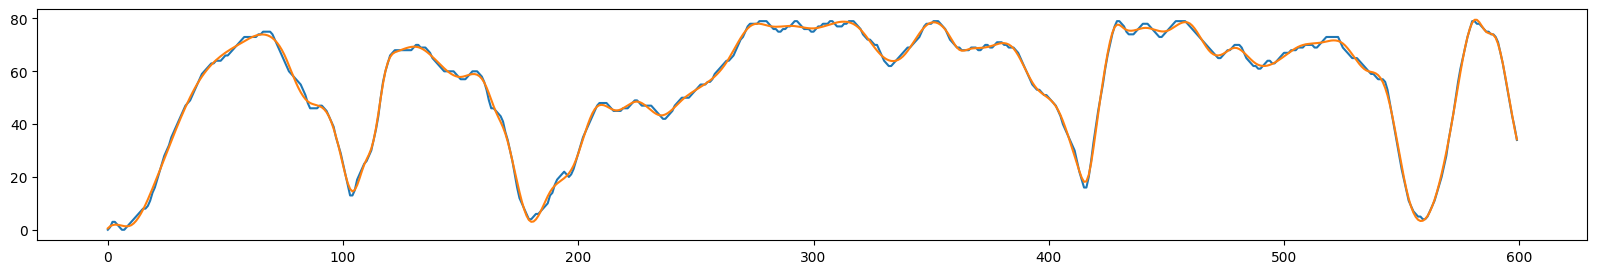

In [75]:
plt.figure()
plt.rcParams["figure.figsize"] = (20,3)
bspl = splrep(dc_pred['time_s'],dc_pred['speed_kmph'],s=np.ceil((p[1]+p[1])/2))
dc_pred['smooth_speed'] = splev(dc_pred['time_s'],bspl)
plt.plot(dc_pred['time_s'],dc_pred['speed_kmph'])
plt.plot(dc_pred['time_s'],dc_pred['smooth_speed'])
plt.show()

In [76]:
dc_pred['speed_noise'] = dc_pred['speed_kmph'] - dc_pred['smooth_speed']

lower_threshold = -10.0  # Set your lower threshold value
upper_threshold = 10.0  # Set your upper threshold value
filtered_df = dc_pred[(dc_pred['speed_noise'] >= lower_threshold) & (dc_pred['speed_noise'] <= upper_threshold)]
filtered_df.reset_index(drop=True, inplace=True)


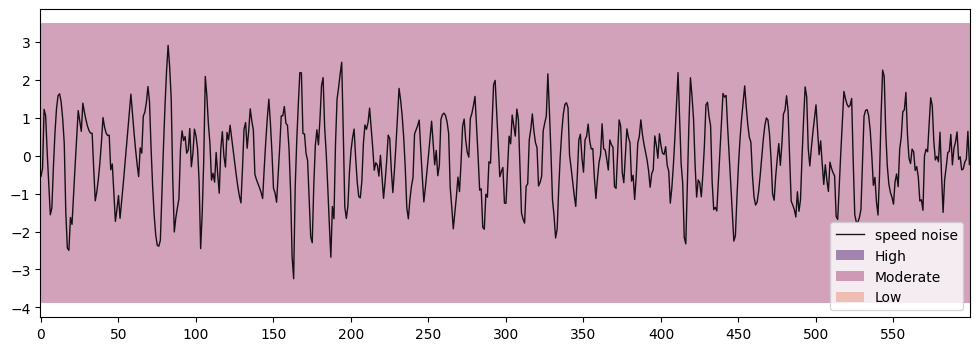

In [77]:
ranges = [-10**6, lower_threshold, upper_threshold, 10**6]
dc_pred['speed_data_classification'] = pd.cut(dc_pred['speed_noise'], ranges, right=False,
                                   labels=["High", "Moderate", "Low"])

fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(dc_pred.index, dc_pred['speed_noise'], color='black', linewidth=1, alpha=0.9, label="speed noise")

sns.barplot(x=dc_pred.index, y=[dc_pred['speed_noise'].min()*1.2] * len(dc_pred),
            hue='speed_data_classification', alpha=0.5, palette='magma', dodge=False, data=dc_pred, ax=ax1)
barp = sns.barplot(x=dc_pred.index, y=[dc_pred['speed_noise'].max()*1.2] * len(dc_pred),
            hue='speed_data_classification', alpha=0.5, palette='magma', dodge=False, data=dc_pred)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

for bar in ax1.patches: # optionally set the bars to fill the complete background, default seaborn sets the width to about 80%
    bar.set_width(1)
# for bar in ax1.patches: # optionally set the bars to fill the complete background, default seaborn sets the width to about 80%
#     bar.set_width(1)
plt.xticks(np.arange(0, len(dc_pred), step=50))
# plt.legend(bbox_to_anchor=(1.02, 1.05) , loc='upper left')
# plt.tight_layout()
plt.show()

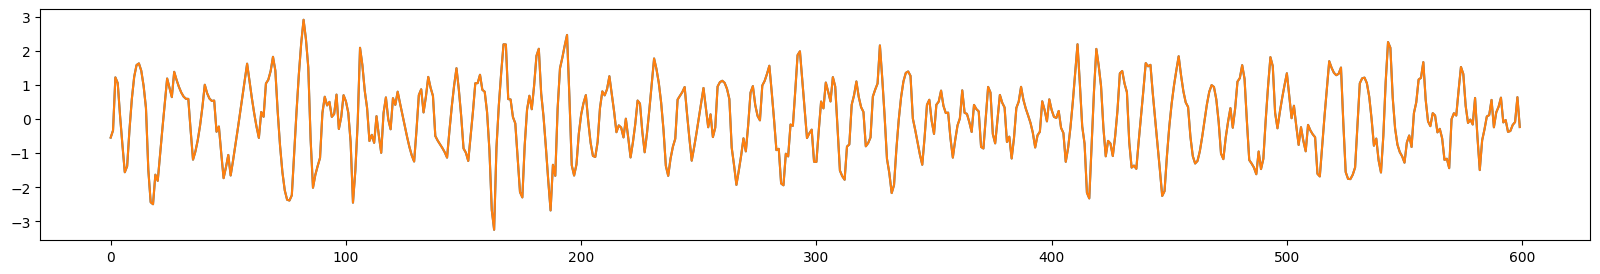

In [78]:
noise_upper = np.ma.masked_where(dc_pred['speed_noise'] > upper_threshold, dc_pred['speed_noise'])
noise_middle = np.ma.masked_where((dc_pred['speed_noise'] > lower_threshold) | (dc_pred['speed_noise'] < upper_threshold), dc_pred['speed_noise'])
noise_lower = np.ma.masked_where(dc_pred['speed_noise'] < lower_threshold, dc_pred['speed_noise'])

fig, ax = plt.subplots()
ax.plot(dc_pred['time_s'], noise_upper, dc_pred['time_s'],noise_lower, dc_pred['time_s'],noise_middle )

plt.show()

In [79]:
lower_threshold = -10.0  # Set your lower threshold value
upper_threshold = 10.0  # Set your upper threshold value
filtered_df = dc_pred[(dc_pred['speed_noise'] >= lower_threshold) & (dc_pred['speed_noise'] <= upper_threshold)]
filtered_df.reset_index(drop=True, inplace=True)

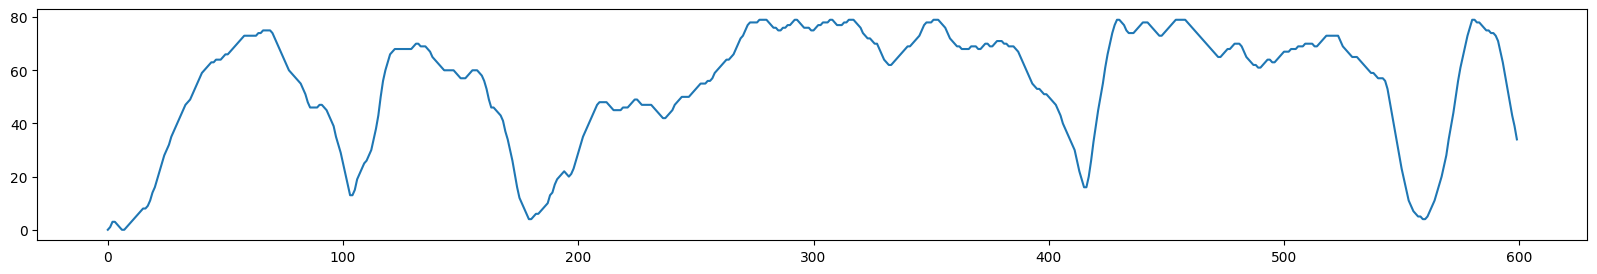

In [80]:
filtered_df['speed_noise'] = filtered_df['speed_kmph'] - filtered_df['smooth_speed']
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(filtered_df['time_s'], filtered_df['speed_kmph'])
# plt.plot(dc_pred['time_s'], dc_pred['speed_kmph'])
plt.show()

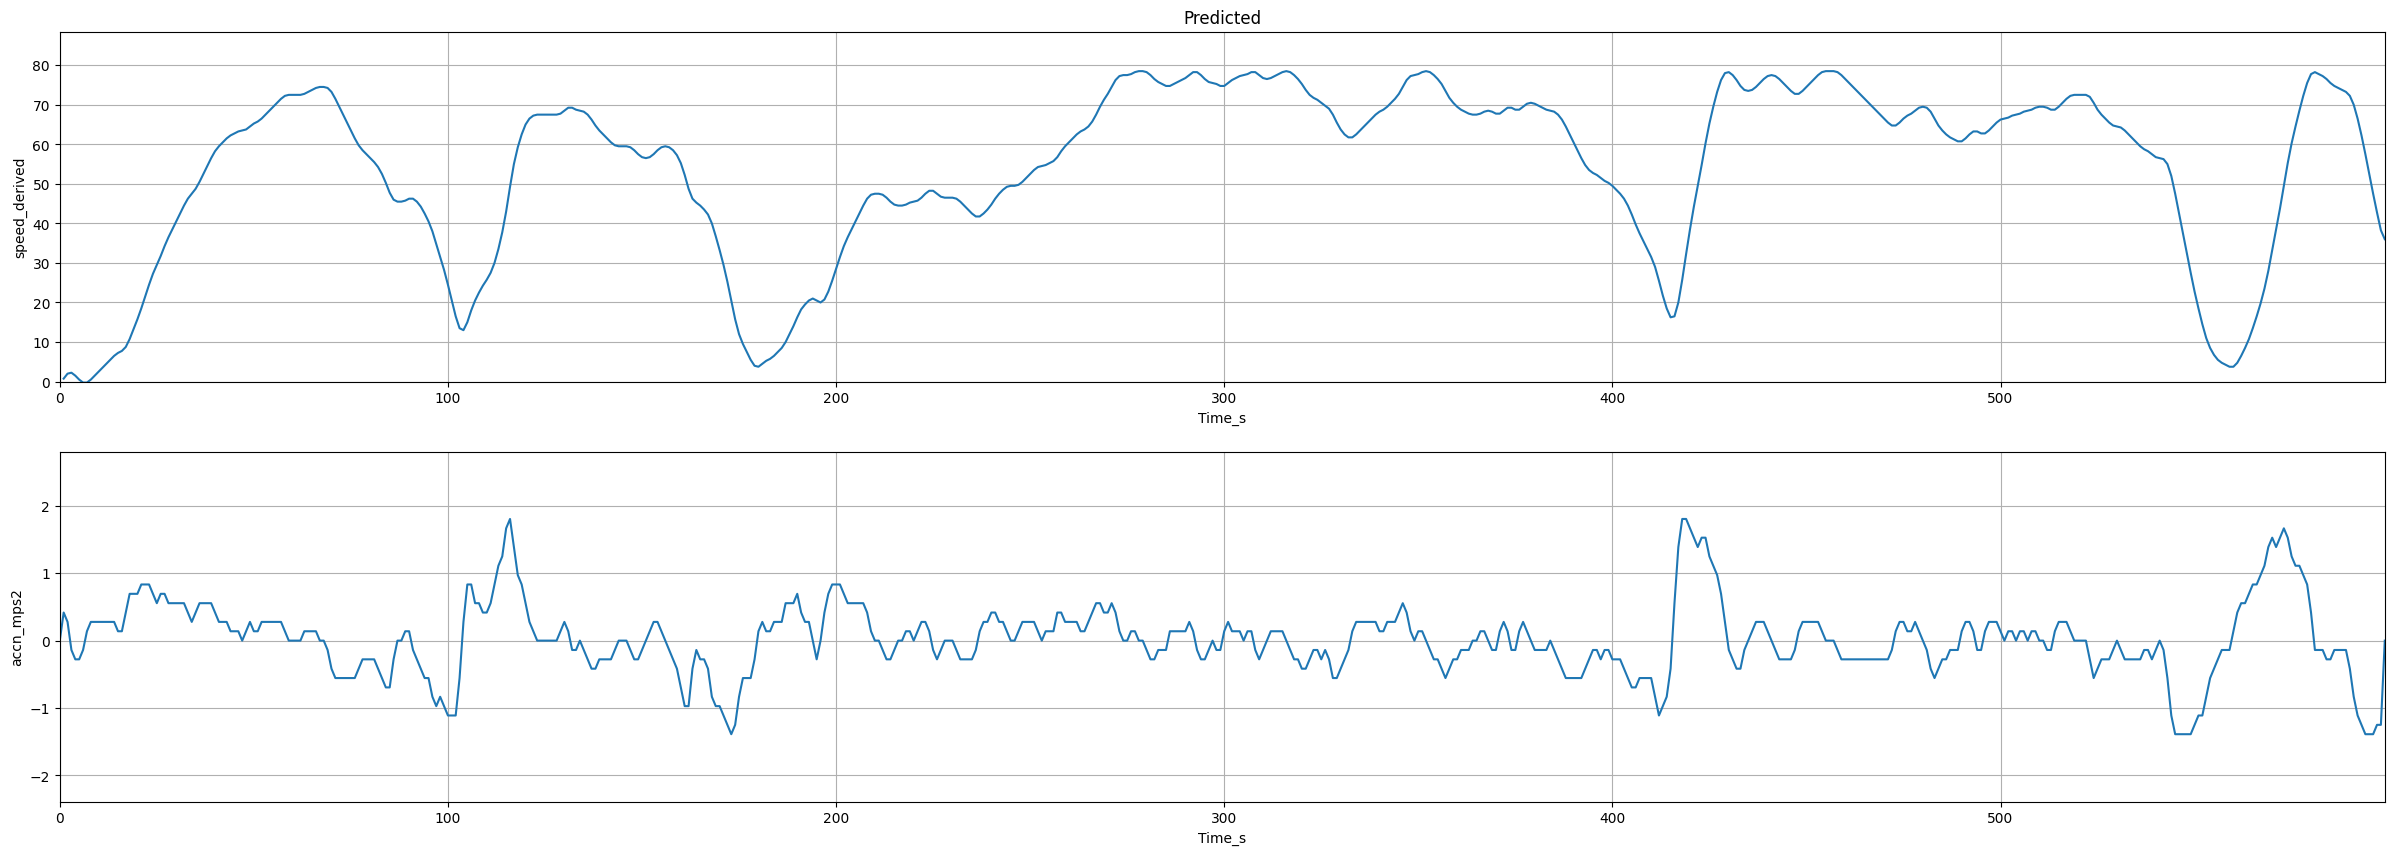

In [81]:
fig,ax = plt.subplots(2,1,figsize=[30,10])


time_interval = filtered_df['time_s'].diff()  # Calculate time intervals
time_interval.iloc[0] = 0  # Set the first interval to 0 to maintain dimensions

# Trapezoidal integration to calculate velocity
speed_derived = ((0.5 * (filtered_df['accn_mps2'] + filtered_df['accn_mps2'].shift(1)) * time_interval).cumsum())*18/5

# Create a new DataFrame for velocity
speed_df = pd.DataFrame({
    "time_s": filtered_df['time_s'],
    'speed_derived': speed_derived
})


#Speed plot
ax[0].plot(speed_df['time_s'],speed_df['speed_derived'])
ax[0].set_xlim([0, speed_df['time_s'].max()])
# ax[0].set_xlim([1000, 1200])
ax[0].set_ylim([0, speed_df['speed_derived'].max()+10])
ax[0].set_title('Predicted')
ax[0].set_xlabel('Time_s')
ax[0].set_ylabel('speed_derived')
ax[0].grid()

#Accn plot
ax[1].plot(filtered_df['time_s'],filtered_df['accn_mps2'])
ax[1].set_xlim([0, filtered_df['time_s'].max()])
# ax[1].set_xlim([1000, 1200])
ax[1].set_ylim([dc_pred['accn_mps2'].min()-1, filtered_df['accn_mps2'].max()+1])
ax[1].set_xlabel('Time_s')
ax[1].set_ylabel('accn_mps2')
ax[1].grid()


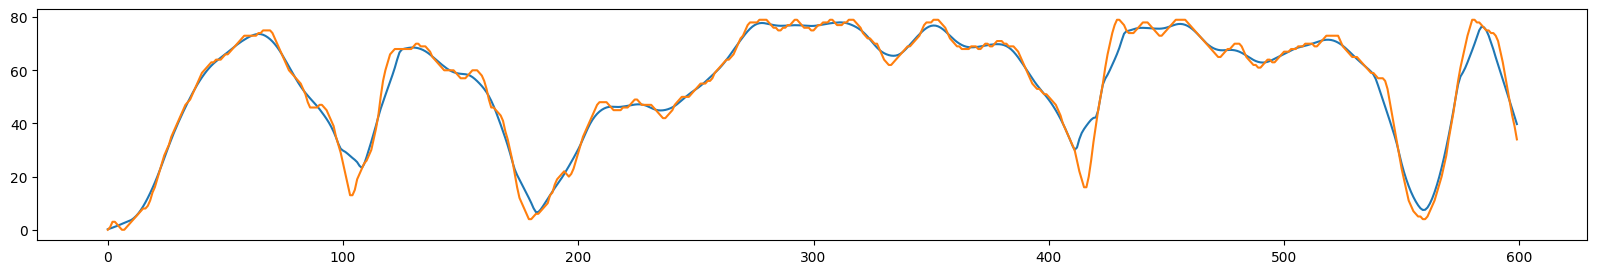

In [82]:
import statsmodels.api as sm

y_lowess = sm.nonparametric.lowess(filtered_df['speed_kmph'], filtered_df['time_s'], frac = 0.035)
filtered_df['smoooth_speed'] = y_lowess[:, 1] # 30 % lowess smoothing
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(filtered_df['time_s'], filtered_df['smoooth_speed'])
plt.plot(filtered_df['time_s'],filtered_df['speed_kmph'])
plt.show()

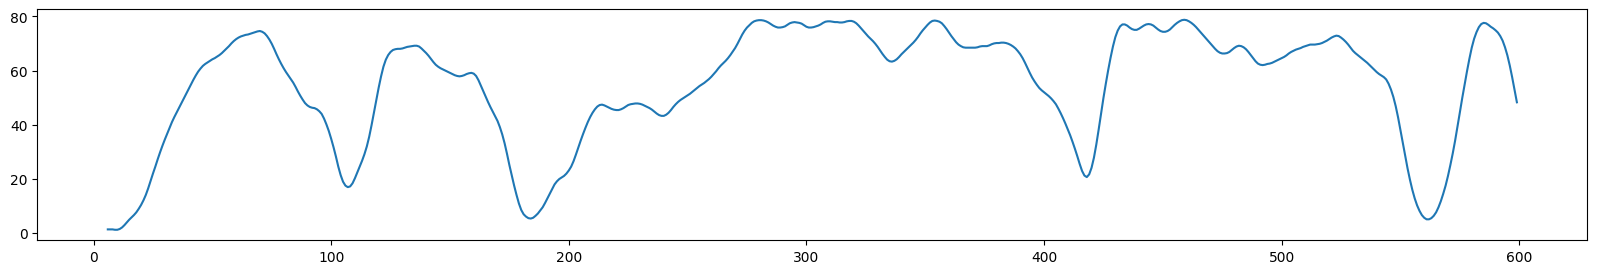

In [83]:
window_size = 7  # Adjust the window size according to your preference

# Calculate the moving average
filtered_df['MA_speed'] = filtered_df['speed_kmph'].rolling(window=window_size, center=False).mean()
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(filtered_df['time_s'], filtered_df['MA_speed'])
# plt.plot(filtered_df['time_s'],filtered_df['speed_kmph'])
plt.show()

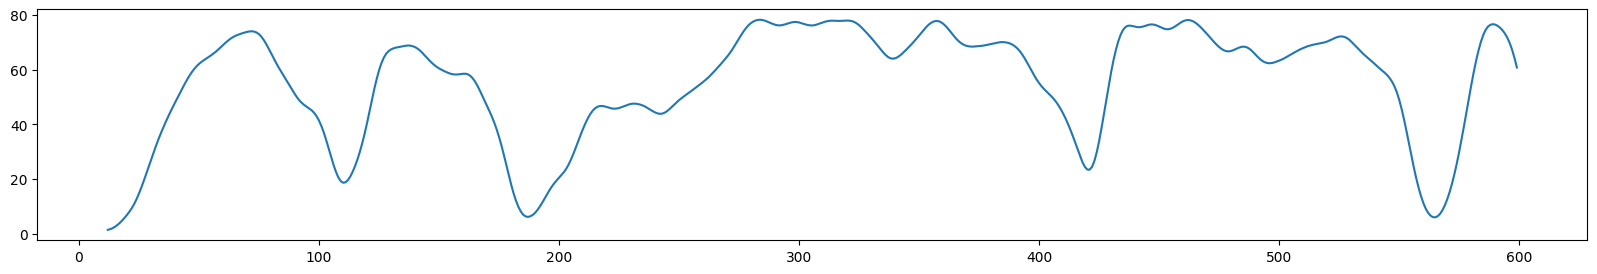

In [84]:
filtered_df['MA2_speed'] = filtered_df['MA_speed'].rolling(window=window_size, center=False).mean()
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(filtered_df['time_s'], filtered_df['MA2_speed'])
# plt.plot(filtered_df['time_s'],filtered_df['speed_kmph'])
plt.show()

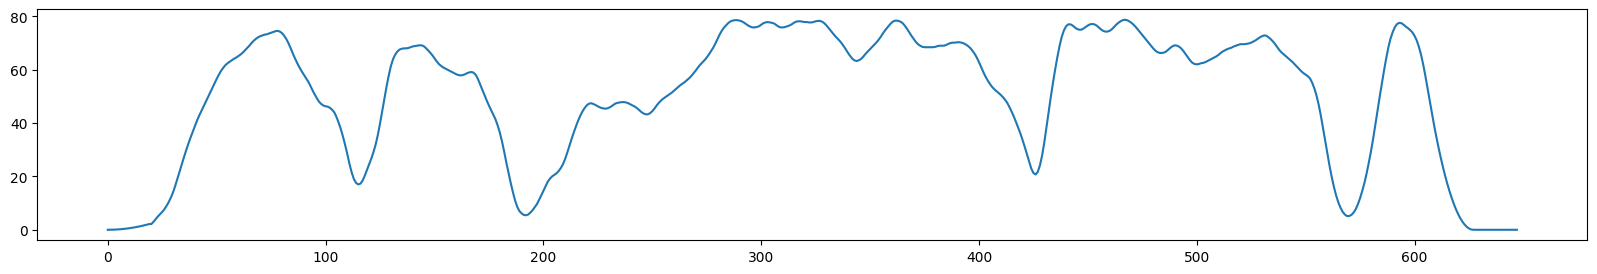

In [85]:

filtered_df = filtered_df.dropna()
# Extract time and speed data
time_data = filtered_df['time_s'].values
speed_data = filtered_df['MA_speed'].values
# print(speed_data)
# Check if first and last data points are non-zero
if speed_data[0] != 0:
    # Extend time and speed data
    n = 20 #adds 3*n datapoints
    time_data = time_data - time_data[0] + n  # to start time with 0
    time_data = np.insert(time_data, 0, np.linspace(0, time_data[0]-1, num=n))
    speed_data = np.insert(speed_data, 0, (np.linspace(0, 1, num=n)**2)*speed_data[0])

if speed_data[-1] != 0:
    # Extend time and speed data
    time_data = np.append(time_data, np.linspace(time_data[-1]+1, time_data[-1] + n, num=n))
    speed_data = np.append(speed_data, (np.linspace(0.95, 0, num=n)**2)*speed_data[-1])
    #inserting zeros at the end
    time_data = np.append(time_data, np.linspace(time_data[-1]+1, time_data[-1] + n, num=n))
    speed_data = np.append(speed_data, (np.linspace(0.95, 0, num=n)**2)*speed_data[-1])
# print(time_data)
# Create a cubic spline to smooth the data
cubic_spline = CubicSpline(time_data, speed_data)

# Generate new time points for extrapolation
extrapolation_time = time_data

# Calculate extrapolated speed values using the cubic spline
extrapolated_speed = cubic_spline(extrapolation_time)

# Create a new DataFrame for extrapolated data
extrapolated_df = pd.DataFrame({
    'time_s': extrapolation_time,
    'speed': extrapolated_speed
})

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(extrapolated_df['time_s'], extrapolated_df['speed'])
# plt.plot(filtered_df['time_s'],filtered_df['speed_kmph'])
plt.show()


In [86]:
def get_drivecycle_stats(df):
    generated_time = df['time_s']
    generated_velocities = df['speed']
    diff = [((generated_velocities[i+1]-generated_velocities[i-1])/3.6)/(generated_time[i+1]-generated_time[i-1]) for i in np.arange(1,len(generated_time)-1)]
    accn_mps2 = np.insert(diff,0,0)
    accn_mps2 = np.append(accn_mps2,0)

    # Compute the derived variables
    distance_covered = (np.trapz(generated_velocities/3.6, x=generated_time))/1000
    max_velocity = np.max(generated_velocities)
    mean_velocity = np.mean(generated_velocities[generated_velocities>0])
    positive_accelerations = accn_mps2[accn_mps2 > 0]
    negative_accelerations = accn_mps2[accn_mps2 < 0]
    max_positive_acceleration = np.max(positive_accelerations) if len(positive_accelerations) > 0 else 0
    mean_positive_acceleration = np.mean(positive_accelerations) if len(positive_accelerations) > 0 else 0
    rms_positive_acceleration = np.sqrt(np.mean(positive_accelerations ** 2)) if len(positive_accelerations) > 0 else 0
    max_negative_acceleration = np.min(negative_accelerations) if len(negative_accelerations) > 0 else 0
    mean_negative_acceleration = np.mean(negative_accelerations) if len(negative_accelerations) > 0 else 0
    rms_negative_acceleration = np.sqrt(np.mean(negative_accelerations ** 2)) if len(negative_accelerations) > 0 else 0

    # Return the drive cycle and the derived variables
    drive_cycle = pd.DataFrame({
        'time_s': generated_time,
        'speed_kmph': generated_velocities,
        'accn_mps2' : accn_mps2,
        # 'p_accn_mps2': generated_accelerations
    })

    derived_variables = {
        'distance_covered': distance_covered,
        'max_velocity': max_velocity,
        'mean_velocity': mean_velocity,
        'max_positive_acceleration': max_positive_acceleration,
        'mean_positive_acceleration': mean_positive_acceleration,
        'rms_positive_acceleration': rms_positive_acceleration,
        'max_negative_acceleration': max_negative_acceleration,
        'mean_negative_acceleration': mean_negative_acceleration,
        'rms_negative_acceleration': rms_negative_acceleration
    }

    return derived_variables
 

In [87]:
print(get_drivecycle_stats(extrapolated_df))

{'distance_covered': 9.19649926900585, 'max_velocity': 78.71428571428571, 'mean_velocity': 52.887216243484104, 'max_positive_acceleration': 1.6071428571428568, 'mean_positive_acceleration': 0.3223417856381845, 'rms_positive_acceleration': 0.478384018314968, 'max_negative_acceleration': -1.3293650793650795, 'mean_negative_acceleration': -0.3600065455735558, 'rms_negative_acceleration': 0.4772206930987555}


In [88]:
print(len(dc_pred), len(extrapolated_df))

600 648


In [89]:
# polynomial fit - computationally intensive 

# import numpy as np
# import matplotlib.pyplot as plt

# plt.figure()
# plt.rcParams["figure.figsize"] = (20,3)
# poly = np.polyfit(dc_pred['time_s'],dc_pred['speed_kmph'],100)
# poly_y = np.poly1d(poly)(dc_pred['time_s'])
# plt.plot(dc_pred['time_s'],poly_y)
# plt.plot(dc_pred['time_s'],dc_pred['speed_kmph'])
# plt.show()